In [1]:
# Cargar librerias
!pip install missingno
!pip install spacy
!python -m spacy download es_core_news_sm

import re #Expresiones regulares
import pandas as pd
import numpy as np
import os # Manejo de ubicaciones
import missingno as msno #Identificar valores faltantes
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import spacy
from spacy.lang.es import stop_words
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from datetime import datetime #Para calcular la edad
%matplotlib inline



     ---------------------------------------- 12.9/12.9 MB 3.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
# Carga de datos
users_raw = pd.read_csv('users_raw.csv')
users = pd.read_csv('users.csv')
#Cambiar el nombre de la primary key en el archivo users_raw.csv por 'user_id'
users_raw.rename(columns={"id": "user_id"}, inplace=True)
# Unión de tablas
merged_df = pd.merge(users, users_raw, on='user_id', how='inner')
df = merged_df
df

,user_id,desired_state,last_role,dreamt_companies,forms_to_work,benefits_sought,my_languages,last_study,level_last_study,interested_areas,...,reactiones_made,match_with_playlists,contents_viewed,connections_sent,created_at,birthdate,gender,city,state,profile_completed
0,1.0,freelancer,CTO,['https://www.apple.com/'],"['virtual', 'mixed', 'in_house']","['bonuses', 'flexible_schedules', 'personal_re...","[['ES', 'advanced'], ['EN', 'advanced', None]]",Ingeniería de Sistemas,other,"['Calidad de Software', 'Formación', 'Tecnolog...",...,NaN,NaN,NaN,2.0,1/7/2016 18:10,11/13/1978,M,Bogotá,Cundinamarca,96
1,9670.0,entrepreneur,Líder en gestión de procesos,"['https://www.rutanmedellin.org/es/', 'http://...","['in_house', 'mixed']","['bonuses', 'study_opportunities', 'scholarshi...",[],Tecnología en sistemas electromecánicos,other,"['Física', 'Diseño', 'Ecología', 'Tecnología',...",...,NaN,NaN,NaN,NaN,8/8/2017 10:04,2/17/1998,F,Medellín,Antioquia,66
2,23825.0,employment,Líder de proyectos Masivos,"['https://www.medtronic.com/co-es/index.html',...","['virtual', 'in_house', 'mixed']","['flexible_schedules', 'study_opportunities', ...",[],Bioingeniería,NaN,"['Starups', 'Marketing Digital Móvil', 'Progra...",...,NaN,NaN,NaN,NaN,4/10/2019 16:57,6/27/1985,M,Medellín,Antioquia,59
3,2245.0,employment,Lider de desarollo,"[None, None, None]",[],[],"[[None, None, None]]",Ingeniería de Sistemas,other,"['Desarrollo de software', 'asf;aslkf;aslkfa;s...",...,NaN,NaN,NaN,5.0,7/25/2016 10:37,10/19/1992,M,Medellín,Antioquia,48
4,24328.0,freelancer,Diseñadora Gráfica Freelancer,"['https://www.kalley.com.co/', 'https://www.ma...",['virtual'],"['study_opportunities', 'flexible_schedules', ...","[[None, None, None]]",Gestión Del Diseño Gráfico,other,"['Diseño gráfico', 'Mercadeo', 'marketing digi...",...,NaN,NaN,NaN,2.0,6/27/2019 12:35,5/9/2001,F,Medellín,Antioquia,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16184,1957325.0,employment,Analista de Datos,"['Google, amazon,']","['remote', 'in_house', 'mixed']","['study_opportunities', 'flexible_schedules', ...","[['EN', 'intermediate', None]]",Ingeniería de Producción,undergraduate,"['Operaciones Y Logística', 'Tecnología', 'Adm...",...,NaN,NaN,NaN,NaN,4/14/2023 16:19,NaN,NaN,Bogotá,Cundinamarca,70
16185,1957347.0,first_job,Diseñadora gráfica,"['Google', 'facebook']","['virtual', 'flexible', 'per_hours']","['study_opportunities', 'flexible_schedules', ...","[['EN', 'basic']]",Diseño industrial,undergraduate,"['Diseño', 'Diseño Grafico', 'Experiencia de...",...,2.0,NaN,NaN,NaN,4/15/2023 9:36,8/5/1997,F,Floridablanca,Santander,52
16186,1957363.0,freelancer,"Periodista, reportero e investigador","['BBC', 'The Guardian', 'Cambio Colombia']",['mixed'],"['salary_increase', 'flexible_schedules', 'per...","[['ES', 'advanced', None], ['EN', 'advanced']]",Periodismo,master_degree,"['Investigación', 'Comunicación Organizacional...",...,NaN,NaN,NaN,NaN,4/15/2023 16:03,NaN,NaN,Cali,Valle del Cauca,51
16187,1957391.0,freelancer,Diseñador gráfico,['Organizaciones con trabajo remoto'],[],['bonuses'],"[['ES', 'advanced', None], ['SIMPLE', 'basic']]",Diseño gráfico,undergraduate,"['Diseño Grafico', 'Ilustración', 'Redes Soci...",...,NaN,NaN,NaN,NaN,4/17/2023 12:23,NaN,NaN,Cali,Valle del Cauca,44


In [3]:
# Verificar los tipos de datos actuales
print(df.dtypes)

user_id                      float64
desired_state                 object
last_role                     object
dreamt_companies              object
forms_to_work                 object
benefits_sought               object
my_languages                  object
last_study                    object
level_last_study              object
interested_areas              object
knowledges                    object
skills                        object
softwares_or_programs         object
methodologies                 object
roles                         object
received_messages            float64
sent_messages                float64
num_resumes_created          float64
events_scheduled             float64
views_to_resume_received     float64
views_to_profile_received    float64
saved_from_playlist          float64
reactions_received           float64
average_feedback             float64
selector_appearances         float64
reactiones_made              float64
match_with_playlists         float64
c

In [4]:
# Cambiar el tipo de dato de las columnas al que corresponde created_at y birthdate a datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['birthdate'] = pd.to_datetime(df['birthdate'])


In [5]:
# Ahora vamos a validar que cada columna tenga valores consistentes
# Este código define una función check_type que recibe un valor y comprueba si es una cadena de caracteres. Si es así, devuelve el valor original, de lo contrario, devuelve el valor predeterminado 'No informa/No Valido'
def check_type(val):
    if isinstance(val, str):
        return val
    else:
        return 'No informa/No Valido'

df['last_role'] = df['last_role'].apply(check_type)
df['my_languages'] = df['my_languages'].apply(check_type)
df['gender'] = df['gender'].apply(check_type)


In [6]:
# Reemplazar los valores no válidos en la columna last_role
df['last_role'] = df['last_role'].replace(['.', '...', 'xx','-', '---', '--'], 'No informa/No Valido')

In [7]:
# reemplazar los valores 0 en la columna "gender" por "No informa/No Valido"
df['gender'] = df['gender'].replace("0", 'No informa/No Valido')
# reemplazar los valores 1 y en la columna "city" por vacio
df['city'] = df['city'].replace("1", '')


In [8]:
# se asume que los valores de fecha tienen el formato "dd/mm/aaaa", se puede utilizar la siguiente expresión regular para correguir los valores de fecha registrados en la columna city.
regex_fecha = r'\d{1,2}/\d{1,2}/\d{4}'
df['city'] = df['city'].replace(to_replace=regex_fecha, value='', regex=True)

In [9]:
#Debemos verificar en las columnas cuantos valores nulos tenemos y decidir que hacer con ellos. luego de estandarizar formatos de las columnas
print(df.isnull().sum())

user_id                          0
desired_state                    0
last_role                        0
dreamt_companies                 0
forms_to_work                    0
benefits_sought                  0
my_languages                     0
last_study                       0
level_last_study               117
interested_areas                 0
knowledges                       0
skills                           0
softwares_or_programs            0
methodologies                    0
roles                            0
received_messages            15940
sent_messages                16149
num_resumes_created          15812
events_scheduled             16153
views_to_resume_received     15921
views_to_profile_received    15446
saved_from_playlist          15894
reactions_received           16084
average_feedback             16112
selector_appearances         15207
reactiones_made              16122
match_with_playlists         16164
contents_viewed              16109
connections_sent    

<AxesSubplot:>

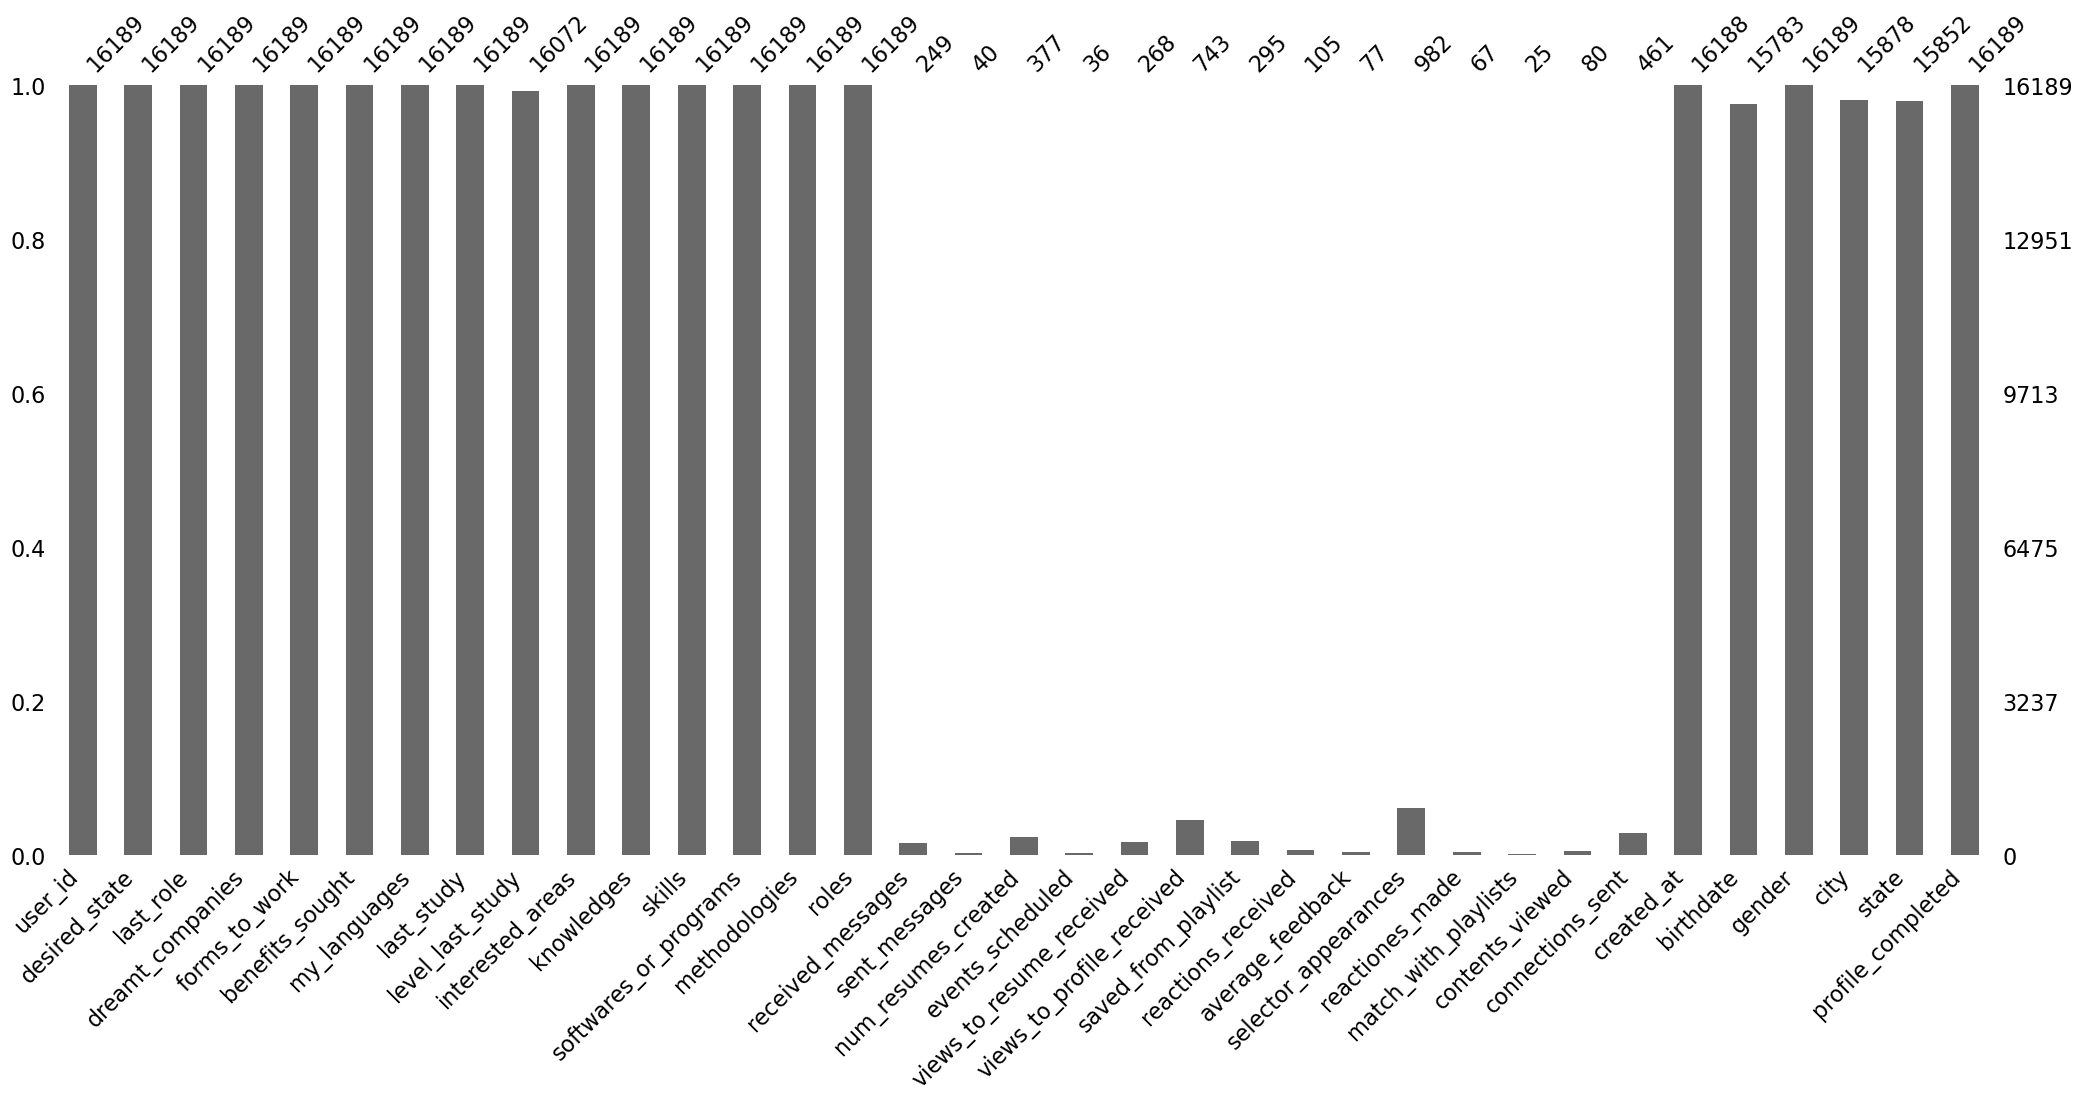

In [10]:
# Graficar los valores faltantes usamos la libreria missingno
msno.bar(df)

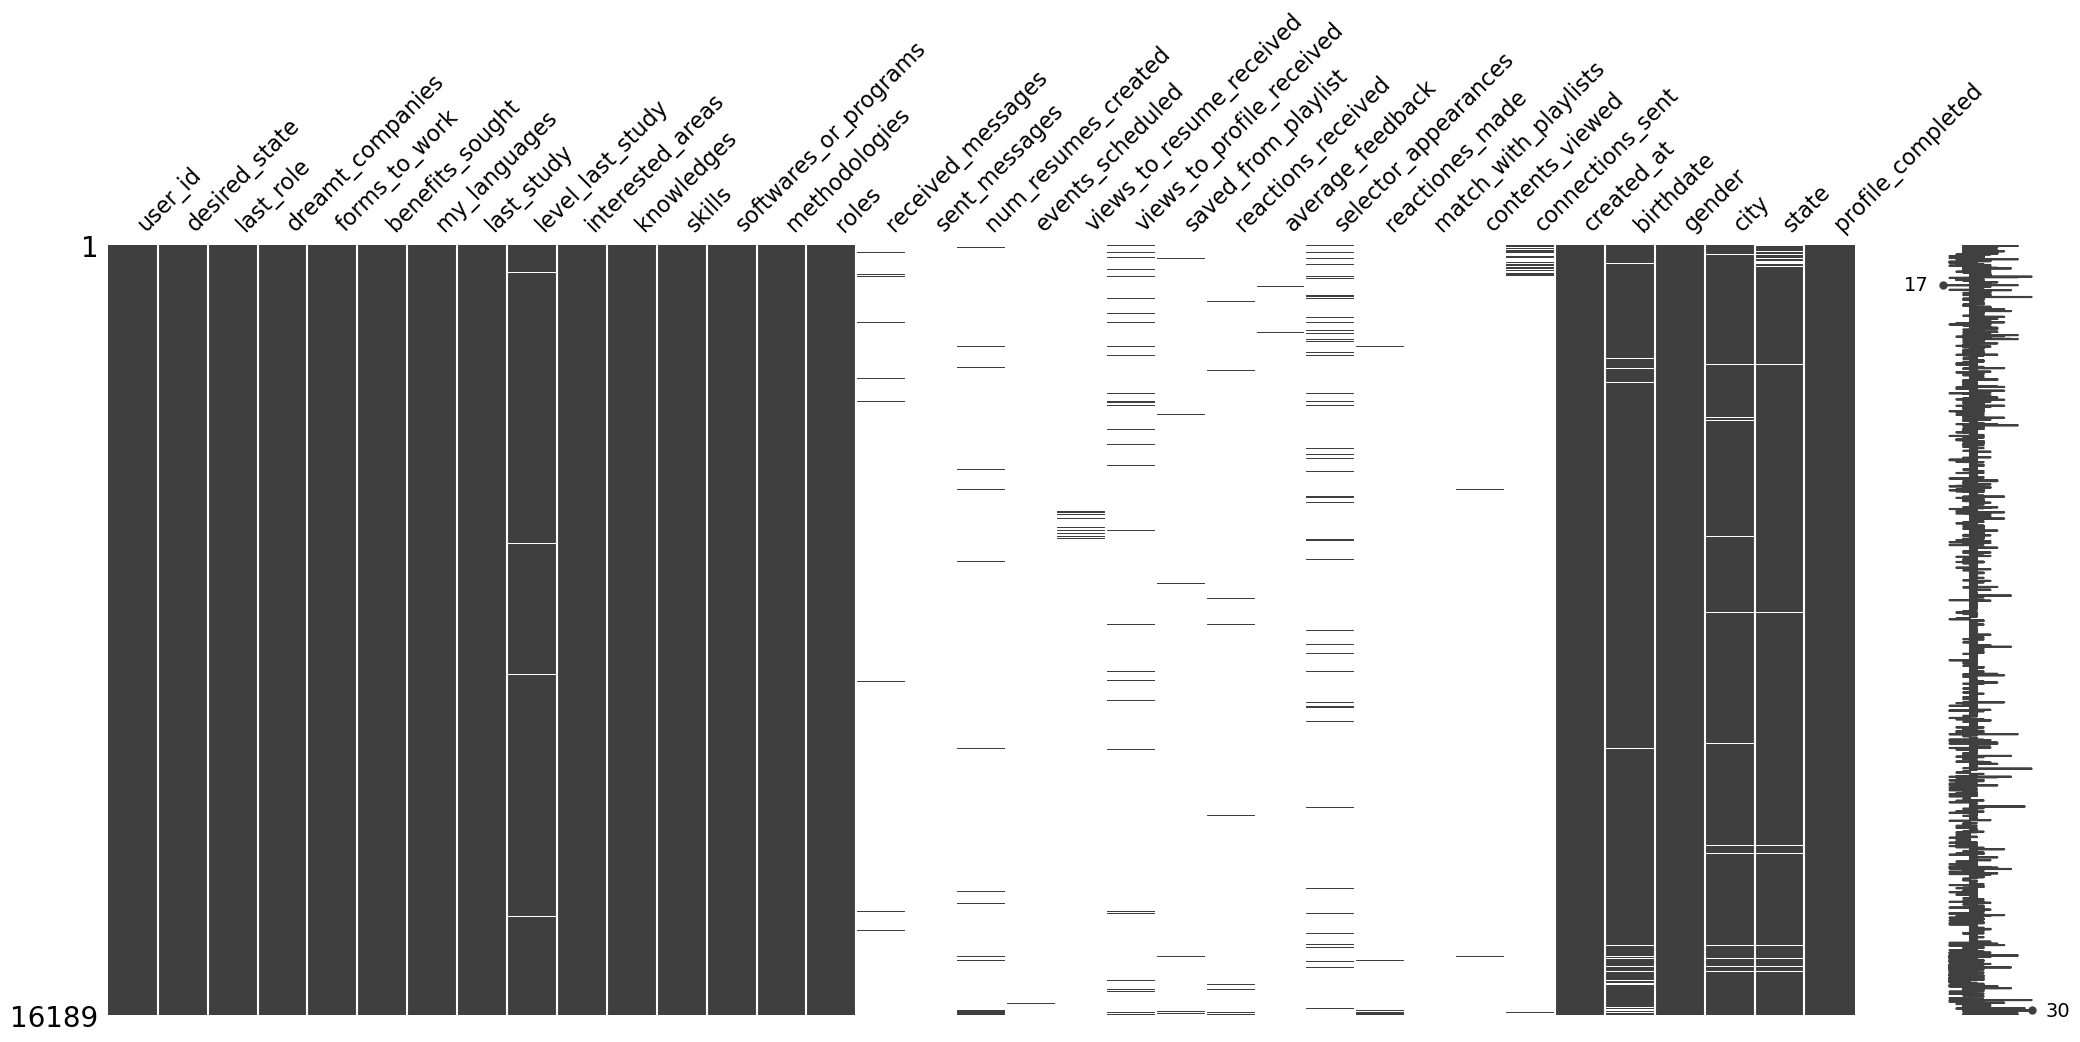

In [11]:
#Para ver graficamente usamos la libreria missingno
msno.matrix(df)
plt.show()


<AxesSubplot:>

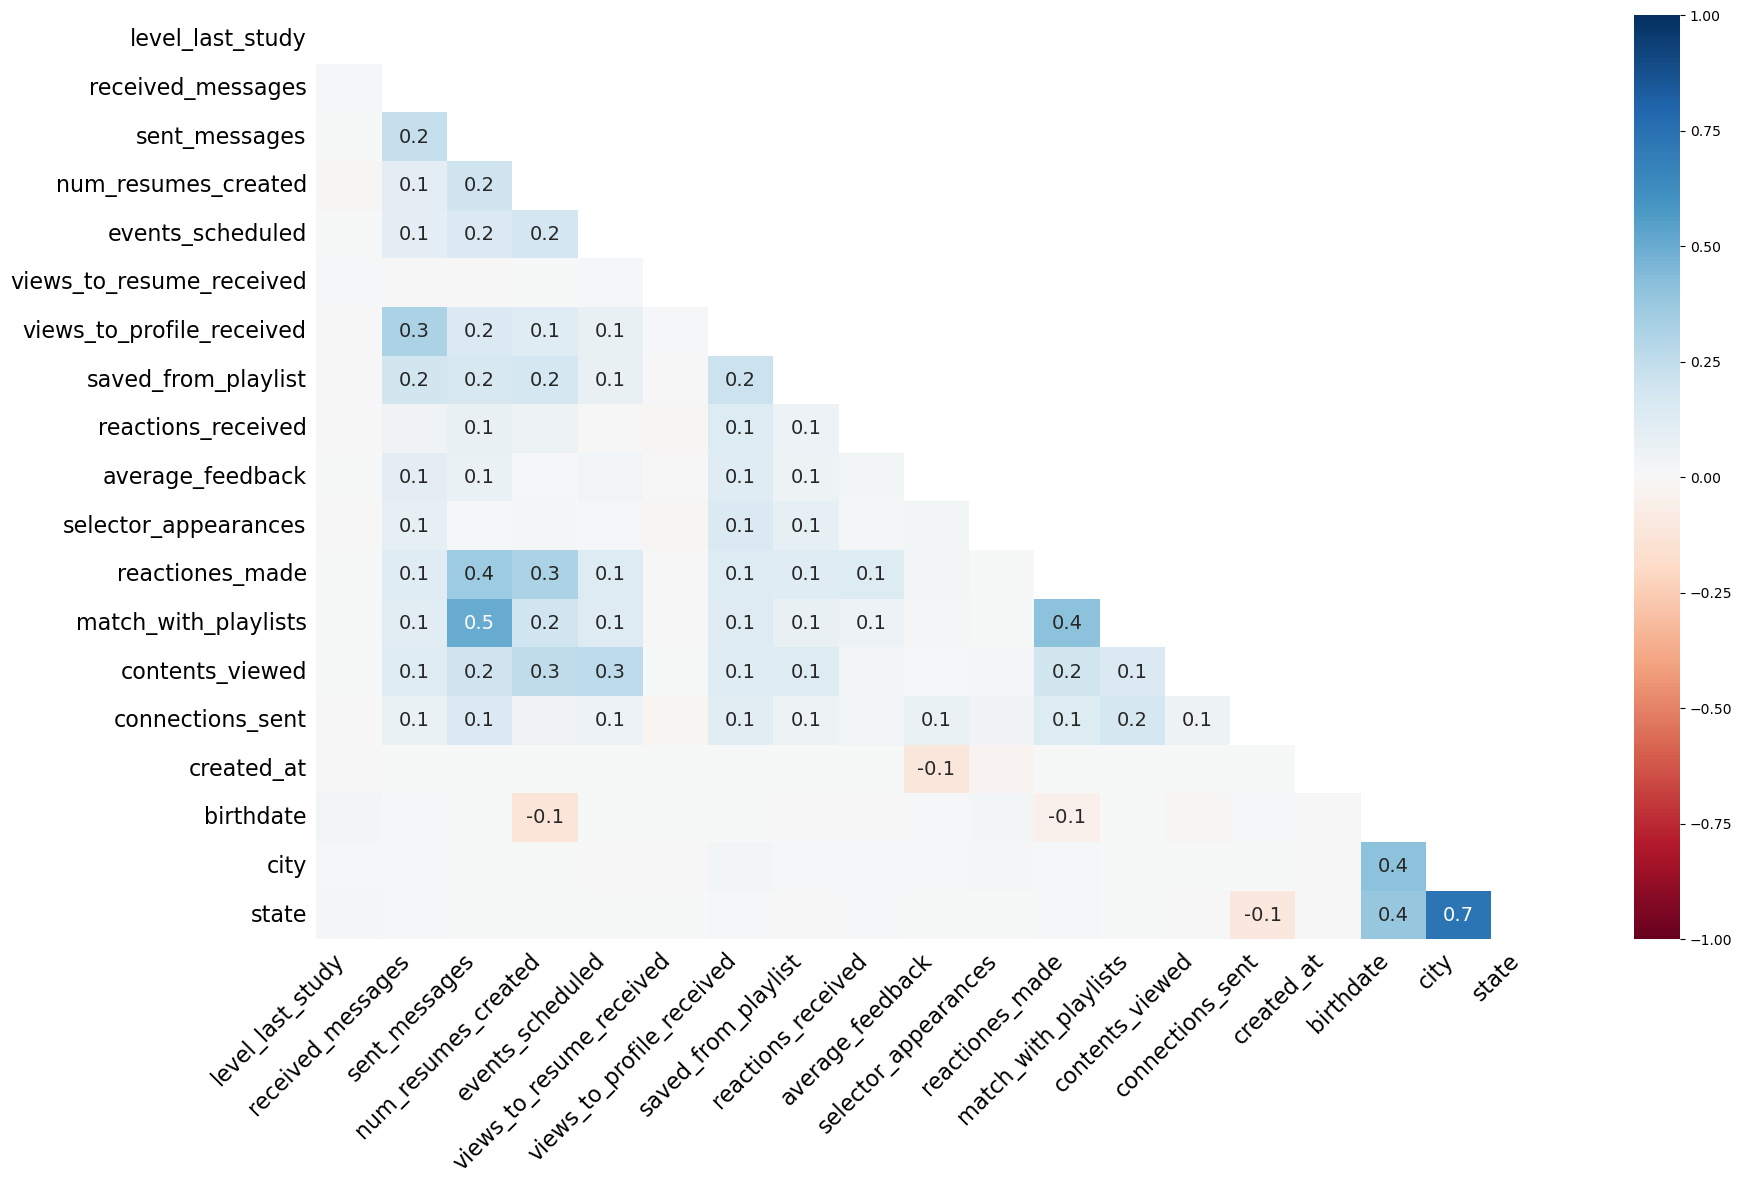

In [12]:
# Usamos la libreria missingno
# Graficar el mapa de calor de correlación de valores faltantes
# las celdas en blanco indican una alta correlación entre los valores faltantes de dos columnas. 
#Si dos columnas tienen una alta correlación, se puede evaluar eliminar una de ellas sin perder mucha información.
msno.heatmap(df)

In [13]:
#Listar las ciudades, para unirficar campos que tengas valores similares
ciudades_unicas = df['city'].unique().tolist()


In [14]:
for ciudad in df['city'].unique().tolist()[:5]:
    estados = df.loc[df['city'] == ciudad, 'state'].unique().tolist()
    print(f"city: {ciudad} | state: {estados}")

city: Bogotá | state: ['Cundinamarca']
city: Medellín | state: ['Antioquia']
city: Popayán | state: ['Cauca']
city: La Ceja | state: ['Antioquia']
city: Bogotá D.C. | state: [nan, 'Cundinamarca', 'Bogota']


In [15]:
#Pasar a string las columnas city y state para poder normalizar. 
df['city'] = df['city'].astype(str)
df['state'] = df['state'].astype(str)
# Convertir todas las letras a mayusculas
df['city'] = df['city'].str.upper()
df['state'] = df['state'].str.upper()
# Remover caracteres especiales, acentos y espacios adicionales
df['city'] = df['city'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode())
df['state'] = df['state'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode())
df['city'] = df['city'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['state'] = df['state'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['city'] = df['city'].str.strip()
df['state'] = df['state'].str.strip()
#Bogotá al ser una ciudad donde la escriben tambien con Bogotá D.C, vamos a unificar en bogota para poder graficar satisfactoriamente
df['city'] = df['city'].replace(['BOGOTA DC'], 'BOGOTA')
df['state'] = df['state'].replace(['BOGOTA DC'], 'BOGOTA')
#Para rellenar los valores faltantes con información que contengan información relacionada entre city y state debido a que  mapa de calor de correlación de valores faltantes tiene un 70%.
df['city'] = df['city'].fillna(df['state'])
df['state'] = df['state'].fillna(df['city'])

In [16]:
#Teniendo que estas columnas son númericas, los valores faltantes se llenaran con 0 para poder aplicar estadisticos y graficos.
cols_to_replace_na = ['received_messages', 'sent_messages', 'num_resumes_created', 'events_scheduled', 'views_to_resume_received', 'views_to_profile_received', 'saved_from_playlist', 'reactions_received', 'average_feedback', 'selector_appearances', 'reactiones_made', 'match_with_playlists', 'contents_viewed', 'connections_sent']
for col in cols_to_replace_na:
    df[col].fillna(0, inplace=True)

In [17]:
# Cargar el modelo en español
nlp = spacy.load("es_core_news_sm")

# Definir las palabras clave para cada nivel de estudio
bachelor_keywords = ["licenciatura", "profesional", "Bioingeniería", "ingeniería", "Bioingeniería"]
master_keywords = ["maestría", "magister","maestria", "Magister","Maestria"]
doctorade_keywords = ["doctorado", "Doctorado","doctor", "PhD"]
specialization_keywords = ["Especialista", "Esp."]
technical_keywords = ["Tecnico", "Tecnica","Técnico", "Técnica"]
technologist_keywords = ["Tecnologa", "Tecnologo","Tecnóloga", "Tecnólogo"]
# Definir la función para encontrar el nivel de estudio
def find_level(text):
    # Convertir a minúsculas y eliminar palabras vacías
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if not token.is_stop]
    
    # Buscar palabras clave para cada nivel de estudio
    for token in tokens:
        if token in bachelor_keywords:
            return 'bachelor'
        elif token in master_keywords:
            return 'master_degree'
        elif token in doctorade_keywords:
            return 'doctorade'
        elif token in specialization_keywords:
            return 'specialization'
        elif token in technical_keywords:
            return 'technical'
        elif token in technologist_keywords:
            return 'technologist'
    
    # Si no se encuentra ningún nivel de estudio, retornar 'other'
    return 'other'
#Reemplazar en lso valores nulos de la columna level_last_study
df['level_last_study'] = df['level_last_study'].fillna(df['last_study'].apply(find_level))

In [18]:
#Dejo estas columnas con el valor vacio, debido a que debe ser correguida la fecha, la ley no permite que un menor de 18 años trabaje. Por esta razón lo dejo nulo para temas estadisticos y calculo de edad. 
df.loc[(df['birthdate'].dt.year >= 2006) & (df['birthdate'].dt.year <= 2023), 'birthdate'] = pd.NaT


In [19]:
# Filtrar el DataFrame por user_id
filtered_df = df.loc[(df['user_id'] >= 49600) & (df['user_id'] <= 49700), ['user_id', 'created_at']]

# Seleccionar la columna created_at y mostrarla
print(filtered_df)

     user_id          created_at
715  49616.0 2020-09-04 11:52:00
716  49618.0 2020-09-04 11:55:00
717  49628.0 2020-09-04 15:23:00
718  49636.0 2020-09-04 20:30:00
719  49665.0                 NaT
720  49676.0 2020-09-07 10:26:00


In [20]:
#Teniendo en cuenta que los user_id son consecutivos, se le asignara al campo cuyo valor es 49665 en user_id, la fecha de creado del user_id 49676
created_at_value = df.loc[df['user_id'] == 49676, 'created_at'].values[0]

# Asignar el valor de created_at del user_id 49676 al user_id 49665
df.loc[df['user_id'] == 49665, 'created_at'] = created_at_value

In [21]:
#PAra validar que tenemos nuestro dataset sin valores faltantes, a exepción de la columna birthdate cuyos valores faltantes son por que no se llenaron o porque fueron fechas invalidas (menores de edad)
print(df.isnull().sum())

user_id                        0
desired_state                  0
last_role                      0
dreamt_companies               0
forms_to_work                  0
benefits_sought                0
my_languages                   0
last_study                     0
level_last_study               0
interested_areas               0
knowledges                     0
skills                         0
softwares_or_programs          0
methodologies                  0
roles                          0
received_messages              0
sent_messages                  0
num_resumes_created            0
events_scheduled               0
views_to_resume_received       0
views_to_profile_received      0
saved_from_playlist            0
reactions_received             0
average_feedback               0
selector_appearances           0
reactiones_made                0
match_with_playlists           0
contents_viewed                0
connections_sent               0
created_at                     0
birthdate 

In [22]:
#Insight Discovery: Top 5 roles con el mayor average_feedback por género
# Agrupar por género y rol, y calcular el promedio de feedback
grouped = df.groupby(['gender', 'last_role'])['average_feedback'].mean().reset_index()
# Ordenar de mayor a menor y seleccionar los Top 5 por género
top_female = grouped[grouped['gender'] == 'F'].nlargest(5, 'average_feedback')
top_male = grouped[grouped['gender'] == 'M'].nlargest(5, 'average_feedback')
top_other = grouped[grouped['gender'] == 'other'].nlargest(5, 'average_feedback')

# Combinar las dos tablas
result = pd.concat([top_female, top_male,top_other])

# Mostrar la tabla resultante
result
#Podemos apreciar que en el genero F es importante verificar a que se refiere el rol "123" que tiene puntuación 5 y es importante resaltar que las personas que se identifican con otro genero "other" tiene el average_feedback en 0

,gender,last_role,average_feedback
1,F,123,5.00
1074,F,Community Planner,5.00
2431,F,Líder de diseño UX/UI,5.00
3398,F,coordinador de sistemas,5.00
77,F,Abogada litigante independiente,4.75
5453,M,"Coordinador Administrativo, Financiero y Comer...",5.00
5846,M,Desarrollador Front-end React.js,5.00
7008,M,Gerente de Proyecto y Scrum Master,5.00
8109,M,Maestro de música en la iglesia y estudiante SENA,5.00
8483,M,Practicante de buses,5.00


In [23]:
#Insight Discovery: promedio views_to_resume_received por city
#Aplicar groupby para agrupar los datos por ciudad y luego aplicar la función mean a la columna views_to_resume_received
views_by_city = df.groupby('city')['views_to_resume_received'].mean().reset_index()
#Ordenar de mayor a menor el promedio
views_by_city = views_by_city.sort_values('views_to_resume_received', ascending=False)
views_by_city

,city,views_to_resume_received
292,MOLAGAVITA,1.0
256,LA UNION,1.0
525,TURBANA,0.5
54,BECERRIL,0.5
490,SUESCA,0.4
...,...,...
193,FUENTE DE ORO,0.0
192,FRONTINO,0.0
191,FREDONIA,0.0
190,FORTUL,0.0


In [24]:
#Insight Discovery: promedio views_to_resume_received por city
#Promedio de las 5 ciudades con mayor promedio de vistas a los currículums recibidos
top_5_views_by_city = views_by_city.head(5)
top_5_views_by_city

,city,views_to_resume_received
292,MOLAGAVITA,1.0
256,LA UNION,1.0
525,TURBANA,0.5
54,BECERRIL,0.5
490,SUESCA,0.4


In [25]:
#Teniendo en cuenta que al tener muchos 0 en la columna views_to_resume_received me puede sesgar los datos, calculo el promedio ignorando los valores 0, para comparar
# Filtrar los valores de 0 en la columna views_to_resume_received
df_filtered = df[df['views_to_resume_received'] != 0]

# Calcular el promedio de views_to_resume_received por ciudad
avg_views_by_city = df_filtered.groupby('city')['views_to_resume_received'].mean()

# Crear una tabla con el resultado
result_table = pd.DataFrame(avg_views_by_city).reset_index()

# Ordenar la tabla por orden descendente de promedio
result_table = result_table.sort_values(by='views_to_resume_received', ascending=False)
result_table

,city,views_to_resume_received
5,BELLO,1.666667
0,ANTIOQUIA,1.000000
46,PIEDECUESTA,1.000000
33,MEDELLIN,1.000000
34,MOLAGAVITA,1.000000
...,...,...
25,IBAGUE,1.000000
26,ITAGUI,1.000000
27,LA ESTRELLA,1.000000
28,LA UNION,1.000000


In [26]:
#Insight Discovery: promedio views_to_resume_received por city
#Promedio de las 5 ciudades con mayor promedio de vistas a los currículums recibidos ignorando los 0 de la columna objetivo
result_table.head(5)

,city,views_to_resume_received
5,BELLO,1.666667
0,ANTIOQUIA,1.000000
46,PIEDECUESTA,1.000000
33,MEDELLIN,1.000000
34,MOLAGAVITA,1.000000


In [27]:
#Insight Discovery:  Top 5 de las compañías soñadas (dreamt_companies) por estado deseado (desired_state) y nivel de último estudio (level_last_study) para usuarios con más de 10 conexiones enviadas (connections_sent)
# Filtrar por usuarios con más de 10 conexiones enviadas
df_filt = df[df['connections_sent'] > 10]

# Explode (función en Pandas que se utiliza para "explotar" o "desagregar" una columna que contiene listas o arrays en múltiples filas) la columna dreamt_companies
df_exploded = df_filt.explode('dreamt_companies')

# Agrupar y contar las compañías soñadas por estado deseado, nivel de último estudio y compañía
df_grouped = df_exploded.groupby(['desired_state', 'level_last_study', 'dreamt_companies'])['dreamt_companies'].count().reset_index(name='count')

# Ordenar por conteo descendente y seleccionar el Top 5 por estado deseado y nivel de último estudio
df_top5 = df_grouped.sort_values(['desired_state', 'level_last_study', 'count'], ascending=[True, True, False]).groupby(['desired_state', 'level_last_study']).head(5)

# Imprimir la tabla resultante
df_top5


,desired_state,level_last_study,dreamt_companies,count
0,employment,technologist,['Facebook'],1
1,employment,undergraduate,"[None, 'https://boweryfarming.com/', 'https://...",1
2,entrepreneur,undergraduate,['https://www.talentpitch.co/'],1
3,first_job,master_degree,['Apple'],1
4,freelancer,undergraduate,['https:www.venturatravel.org/'],1


In [28]:
#Insight Discovery(Creación propia): Top 5 habilidades mas comunes (skills) por  usuarios con promedio de comentarios (average_feedback) mayor que 4.
# filtrar usuarios con average_feedback > 4
df_skills = df[df['average_feedback']>4].explode('skills')
df_skills = df_skills[['skills', 'average_feedback']]



In [29]:
# Definir la función que se encargará de separar cada valor de la columna 'skills' en cinco nuevas columnas
def separate_skills(row):
    skills_list = row['skills'].split(',')
    n_skills = len(skills_list)
    if n_skills == 0:
        row['skill1'] = 0
        row['skill2'] = 0
        row['skill3'] = 0
        row['skill4'] = 0
        row['skill5'] = 0
    elif n_skills == 1:
        row['skill1'] = skills_list[0].strip()
        row['skill2'] = 0
        row['skill3'] = 0
        row['skill4'] = 0
        row['skill5'] = 0
    elif n_skills == 2:
        row['skill1'] = skills_list[0].strip()
        row['skill2'] = skills_list[1].strip()
        row['skill3'] = 0
        row['skill4'] = 0
        row['skill5'] = 0
    elif n_skills == 3:
        row['skill1'] = skills_list[0].strip()
        row['skill2'] = skills_list[1].strip()
        row['skill3'] = skills_list[2].strip()
        row['skill4'] = 0
        row['skill5'] = 0
    elif n_skills == 4:
        row['skill1'] = skills_list[0].strip()
        row['skill2'] = skills_list[1].strip()
        row['skill3'] = skills_list[2].strip()
        row['skill4'] = skills_list[3].strip()
        row['skill5'] = 0
    else:
        row['skill1'] = skills_list[0].strip()
        row['skill2'] = skills_list[1].strip()
        row['skill3'] = skills_list[2].strip()
        row['skill4'] = skills_list[3].strip()
        row['skill5'] = skills_list[4].strip()
    return row

# Aplicar la función a cada fila del DataFrame
df_skills = df[df['average_feedback']>4]
df_skills = df_skills.apply(separate_skills, axis=1)

# Seleccionar únicamente las columnas necesarias
df_skills = df_skills[['skills', 'average_feedback', 'last_study', 'skill1', 'skill2', 'skill3', 'skill4', 'skill5']]

#Eliminamos la columna skills
df_skills = df_skills.drop('skills', axis=1)


In [30]:
#Limpiar las columnas skills 
df_skills['skill1'] = df_skills['skill1'].str.replace('[\'\[\]]', '')
df_skills['skill2'] = df_skills['skill2'].str.replace('[\'\[\]]', '')
df_skills['skill3'] = df_skills['skill3'].str.replace('[\'\[\]]', '')
df_skills['skill4'] = df_skills['skill4'].str.replace('[\'\[\]]', '')
df_skills['skill5'] = df_skills['skill5'].str.replace('[\'\[\]]', '')


C:\Users\marce\AppData\Local\Temp\ipykernel_8616\3937110956.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_skills['skill1'] = df_skills['skill1'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\3937110956.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_skills['skill2'] = df_skills['skill2'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\3937110956.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_skills['skill3'] = df_skills['skill3'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\3937110956.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_skills['skill4'] = df_skills['skill4'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\3937110956.py:6: Future

In [31]:
# Se unifica en una columna Skill , los campos del 'skill1', 'skill2', 'skill3', 'skill4', 'skill5'
df_skills_melt = df_skills.melt(id_vars=['average_feedback'], value_vars=['skill1', 'skill2', 'skill3', 'skill4', 'skill5'], var_name='skill_no', value_name='skill')
#Se eliminan los valores nulos en la columna skill
df_skills_melt = df_skills_melt.dropna(subset=['skill']).reset_index(drop=True)
#Muestra las 5 habilidades con promedio de comentarios superior a 4
top_skills = df_skills_melt['skill'].value_counts().head(5)
top_skills



Aprendizaje             8
Adaptabilidad           7
Adaptación al Cambio    6
Trabajo en Equipo       6
Actitud Positiva        5
Name: skill, dtype: int64

In [32]:
# Definir la función que se encargará de separar cada valor de la columna 'forms_to_work' en cinco nuevas columnas
def separate_forms(row):
    forms_list = row['forms_to_work'].split(',')
    n_forms = len(forms_list)
    if n_forms == 0:
        row['form1'] = 0
        row['form2'] = 0
        row['form3'] = 0
        row['form4'] = 0
        row['form5'] = 0
    elif n_forms == 1:
        row['form1'] = forms_list[0].strip()
        row['form2'] = 0
        row['form3'] = 0
        row['form4'] = 0
        row['form5'] = 0
    elif n_forms == 2:
        row['form1'] = forms_list[0].strip()
        row['form2'] = forms_list[1].strip()
        row['form3'] = 0
        row['form4'] = 0
        row['form5'] = 0
    elif n_forms == 3:
        row['form1'] = forms_list[0].strip()
        row['form2'] = forms_list[1].strip()
        row['form3'] = forms_list[2].strip()
        row['form4'] = 0
        row['form5'] = 0
    elif n_forms == 4:
        row['form1'] = forms_list[0].strip()
        row['form2'] = forms_list[1].strip()
        row['form3'] = forms_list[2].strip()
        row['form4'] = forms_list[3].strip()
        row['form5'] = 0
    else:
        row['form1'] = forms_list[0].strip()
        row['form2'] = forms_list[1].strip()
        row['form3'] = forms_list[2].strip()
        row['form4'] = forms_list[3].strip()
        row['form5'] = forms_list[4].strip()
    return row

In [33]:
#Visualización: Gráfica de barras apiladas de forms_to_work por level_last_study.
# creando una tabla de contingencia de forms_to_work y level_last_study

df_work_study = df[['forms_to_work', 'level_last_study']].copy()
# Aplicar la función a cada fila del DataFrame
df_work_study = df_work_study.apply(separate_forms, axis=1)
#Eliminamos la columna forms_to_work
df_work_study = df_work_study.drop('forms_to_work', axis=1)


In [34]:
#Limpiar las columnas form 
df_work_study['form1'] = df_work_study['form1'].str.replace('[\'\[\]]', '')
df_work_study['form2'] = df_work_study['form2'].str.replace('[\'\[\]]', '')
df_work_study['form3'] = df_work_study['form3'].str.replace('[\'\[\]]', '')
df_work_study['form4'] = df_work_study['form4'].str.replace('[\'\[\]]', '')
df_work_study['form5'] = df_work_study['form5'].str.replace('[\'\[\]]', '')


C:\Users\marce\AppData\Local\Temp\ipykernel_8616\2490407454.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_work_study['form1'] = df_work_study['form1'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\2490407454.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_work_study['form2'] = df_work_study['form2'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\2490407454.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_work_study['form3'] = df_work_study['form3'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616\2490407454.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_work_study['form4'] = df_work_study['form4'].str.replace('[\'\[\]]', '')
C:\Users\marce\AppData\Local\Temp\ipykernel_8616

In [35]:
# Se unifica en una columna forms_to_work , los campos del de form
df_work_study_melt = df_work_study.melt(id_vars=['level_last_study'], value_vars=['form1', 'form2', 'form3', 'form4', 'form5'], var_name='form_no', value_name='forms_to_work')


In [36]:
#Se eliminan los valores nulos en la columna forms_to_work
df_work_study_melt = df_work_study_melt.dropna(subset=['forms_to_work']).reset_index(drop=True)

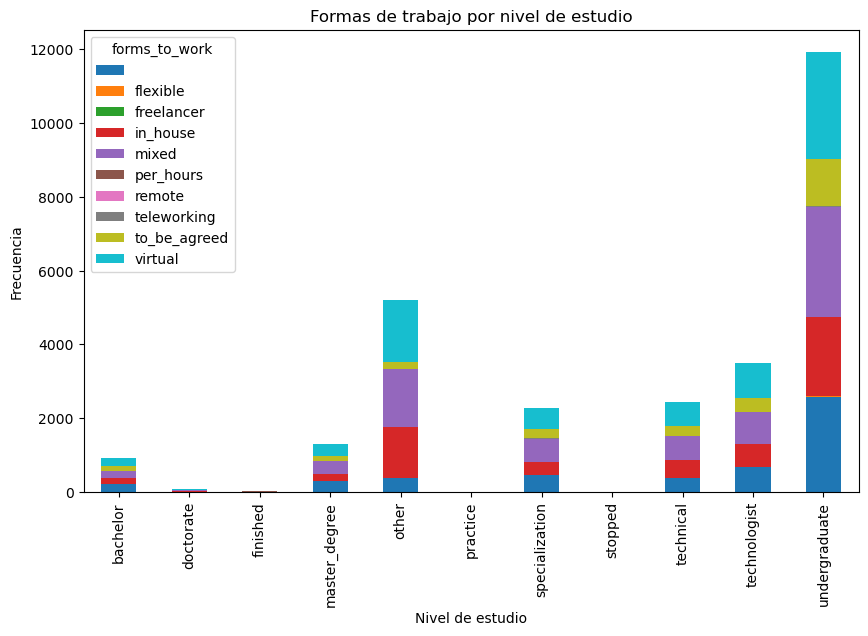

In [37]:
# creamos una tabla de contingencia
ct = pd.crosstab(df_work_study_melt['level_last_study'], df_work_study_melt['forms_to_work'])

# creamos el stacked bar plot
ax = ct.plot.bar(stacked=True, figsize=(10,6))

# configuramos los ejes y los títulos
ax.set_xlabel('Nivel de estudio')
ax.set_ylabel('Frecuencia')
ax.set_title('Formas de trabajo por nivel de estudio')

# mostramos la figura
plt.show()









In [38]:
#Visualization: Scatter plot of age vs. average_feedback
#Sacamos un nuevo dt con las columnas de interes
df_feedback_age = df.loc[:, ['average_feedback', 'birthdate']]
# Se obtiene la fecha actual
now = datetime.now()
# Se define una función que calcule la edad a partir de una fecha de nacimiento
def calculate_age(birthdate):
    age = now.year - birthdate.year - ((now.month, now.day) < (birthdate.month, birthdate.day))
    return age
# Se aplica la función a la columna de birthdate y se guarda el resultado en una nueva columna 'age'
df_feedback_age['age'] = df_feedback_age['birthdate'].apply(calculate_age)
# Eliminar las filas que no contengan edad, para evitar el sesgo de la data
df_feedback_age.dropna(subset=['age'], inplace=True)
# Eliminar filas con edad mayor a 70, debido a que mayor a esta edad debe estar en jubilación
df_feedback_age = df_feedback_age[df_feedback_age['age'] <= 70]


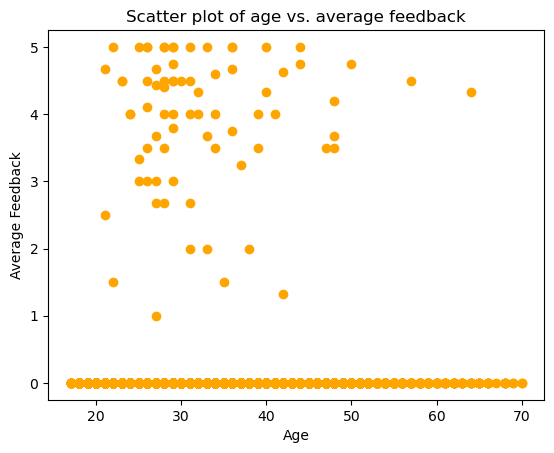

In [39]:
#Visualization: Scatter plot of age vs. average_feedback
plt.scatter(df_feedback_age['age'], df_feedback_age['average_feedback'], color='orange')
plt.xlabel('Age')
plt.ylabel('Average Feedback')
plt.title('Scatter plot of age vs. average feedback')
plt.show()

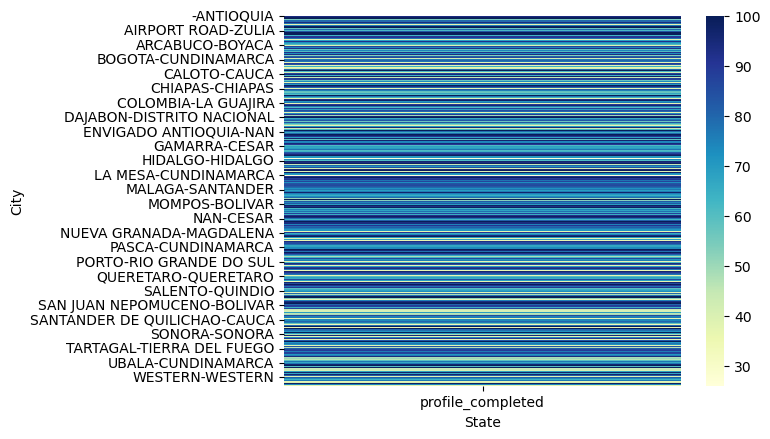

In [40]:
#Visualization: Heatmap of profile_completed by city and state .
# Creamos una tabla pivote de profile_completed por ciudad y estado
pivot_table = pd.pivot_table(df, index=['city', 'state'], values='profile_completed', aggfunc=np.mean)

# Creamos el Heatmap con Seaborn
sns.heatmap(pivot_table, cmap='YlGnBu')

# Configuramos las etiquetas del eje x y y
plt.xlabel('State')
plt.ylabel('City')

# Mostramos el Heatmap
plt.show()

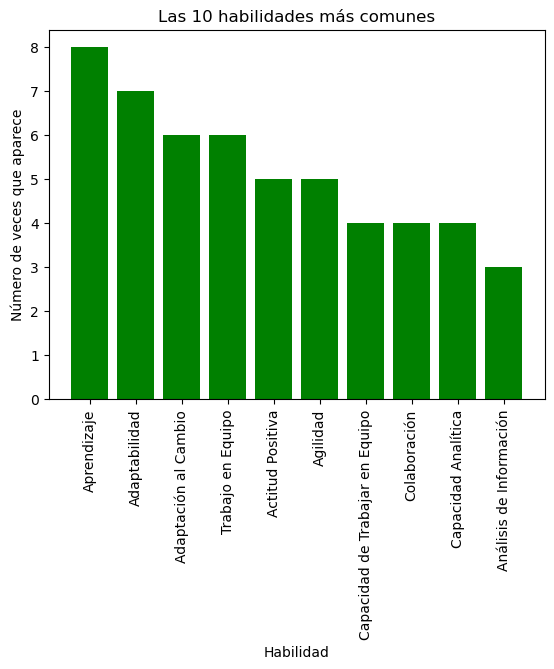

In [41]:
# Obtener el conteo de habilidades
skill_counts = df_skills_melt['skill'].value_counts()

# Seleccionar las 10 habilidades más comunes
top_skills = skill_counts.head(10)

# Crear un gráfico de barras
plt.bar(top_skills.index, top_skills.values, color='green')

# Configurar el título y etiquetas de los ejes
plt.title('Las 10 habilidades más comunes')
plt.xlabel('Habilidad')
plt.ylabel('Número de veces que aparece')
# Ajustar el tamaño del eje x
plt.xticks(rotation=90, fontsize=10)
# Mostrar el gráfico
plt.show() 


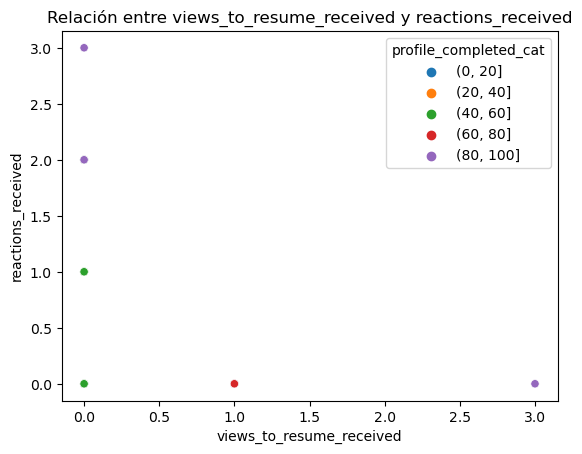

In [42]:
# Agrupar los valores de profile_completed en intervalos de 20
df['profile_completed_cat'] = pd.cut(df['profile_completed'], bins=range(0, 101, 20))

# Crear el scatter plot con Seaborn
sns.scatterplot(data=df, x='views_to_resume_received', y='reactions_received', hue='profile_completed_cat')

# Configurar el título y etiquetas de los ejes
plt.title('Relación entre views_to_resume_received y reactions_received')
plt.xlabel('views_to_resume_received')
plt.ylabel('reactions_received')

# Mostrar el gráfico
plt.show()


In [43]:
!pip freeze > requirements.txt